In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

def init_params(data):
    # Initialise the means and standard deviations for each dist randomly
    mu1, mu2 = np.random.choice(data, 2, replace=False)
    sigma1, sigma2 = np.std(data), np.std(data)
    # At first, assume that each distribution has the same weight
    pi = 0.5
    return mu1, mu2, sigma1, sigma2, pi

Define function for the PDF of the Normal distribution
$$
f(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{(x - \mu)^2}{2 \sigma^2} \right)
$$

In [ ]:
def normal_pdf(x, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

The **objective function** is the likelihood, which is the "probability" that the given parameters fit the data.
$$
L(\mu, \sigma^2) = \prod_{i=1}^{N} \mathcal{N}(x_i \mid \mu, \sigma^2)
$$

Instead of using likelihood to maximise the parameters, log likelihood is used instead because of its additive properties. In the end, the maximum point (derivative = 0) will still be the same.

$$
\log L(\mu, \sigma^2) = -\frac{N}{2} \log(2 \pi \sigma^2) - \frac{1}{2 \sigma^2} \sum_{i=1}^{N} (x_i - \mu)^2
$$

In [ ]:
def log_likelihood(data, mu1, mu2, sigma1, sigma2, pi):
    return np.sum(np.log(pi * normal_pdf(data, mu1, sigma1) + (1 - pi) * normal_pdf(data, mu2, sigma2)))

The expectation step calculates the posterior distribution for each component and data point. Essentially, it assigns a probability to each data point to decide whether it is in distribution 1 or 2.

$$
r_{nk} = \frac{\pi_{k} \mathcal{N}\left(x_{n} \mid \mu_{k}, \sigma_{k}\right)}{\sum_{j=1}^{K} \pi_{j} \mathcal{N}\left(x_{n} \mid \mu_{j}, \sigma_{j}\right)}.
$$

In [ ]:
def expectation_step(data, mu1, mu2, sigma1, sigma2, pi):
    rn1 = pi * normal_pdf(data, mu1, sigma1)
    rn2 = (1 - pi) * normal_pdf(data, mu2, sigma2)
    rnj = rn1 + rn2
    rn1 /= rnj
    rn2 /= rnj
    return rn1, rn2

The maximization step calculates the new mean, standard deviation and weighted values.

$$
\mu_{k} =\frac{1}{N_{k}} \sum_{n=1}^{N} r_{n k} x_{n}, \quad
\sigma_{k} =\frac{1}{N_{k}} \sum_{n=1}^{N} r_{n k}\left(x_{n}-\mu_{k}\right)^{2}, \quad
\pi_{k} =\frac{N_{k}}{N},
$$

In [ ]:
def maximization_step(data, rn1, rn2):
    N1 = np.sum(rn1)
    N2 = np.sum(rn2)
    mu1 = np.sum(rn1 * data) / N1
    mu2 = np.sum(rn2 * data) / N2
    sigma1 = np.sqrt(np.sum(rn1 * (data - mu1) ** 2) / N1)
    sigma2 = np.sqrt(np.sum(rn2 * (data - mu2) ** 2) / N2)
    pi = N1 / (N1 + N2)
    return mu1, mu2, sigma1, sigma2, pi

Use a tolerance level to check whether the likelihood has reached its maximum

$$
-\sum_{n=1}^{N}\left[\log \left(\frac{1}{\sqrt{2 \pi \sigma^{2}}}\right)-\frac{\left(x_{n}-\mu\right)^{2}}{2 \sigma^{2}}\right] < \epsilon
$$

In [ ]:
def em_algorithm(data, tol=1e-3, max_iter=100):
    mu1, mu2, sigma1, sigma2, pi = init_params(data)
    log_likelihoods = []

    # Repeat until it reaches maximum loops or it doesn't improve
    for i in range(max_iter):
        rn1, rn2 = expectation_step(data, mu1, mu2, sigma1, sigma2, pi)
        mu1, mu2, sigma1, sigma2, pi = maximization_step(data, rn1, rn2)
        log_likelihoods.append(log_likelihood(data, mu1, mu2, sigma1, sigma2, pi))
        if i > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return mu1, mu2, sigma1, sigma2, pi, log_likelihoods

In [ ]:
data1 = np.random.normal(loc=0, scale=1, size=100)
data2 = np.random.normal(loc=3, scale=2, size=100)
data = np.concatenate((data1, data2))

In [ ]:
mu1, mu2, sigma1, sigma2, pi, log_likelihoods = em_algorithm(data, tol=1e-3, max_iter=100)

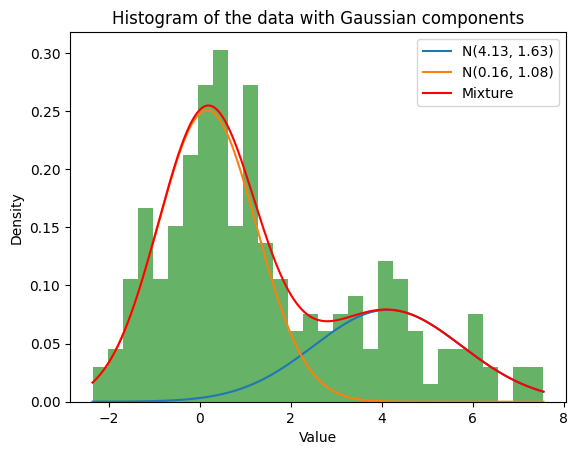

In [ ]:
# Plot the data
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Plot the estimated Gaussian components
x = np.linspace(min(data), max(data), 1000)
y1 = pi * norm.pdf(x, mu1, sigma1)
y2 = (1 - pi) * norm.pdf(x, mu2, sigma2)

plt.plot(x, y1, label=f'N({mu1:.2f}, {sigma1:.2f})')
plt.plot(x, y2, label=f'N({mu2:.2f}, {sigma2:.2f})')
plt.plot(x, y1 + y2, label='Mixture', color='red')

# Show the plot
plt.title('Histogram of the data with Gaussian components')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


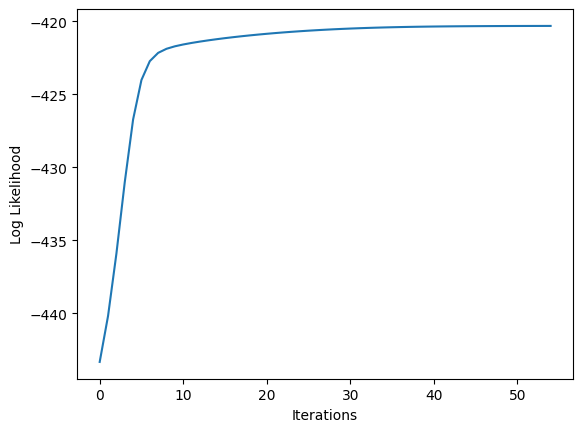

In [ ]:
plt.plot(log_likelihoods)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.show()